In [39]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
import seaborn as sns


In [3]:
# global variables 
# test
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()
yesterday

datetime.date(2023, 4, 30)

In [79]:
# method for getting close prices on a list of stocks
# important - don't put unnecessary spaces in the tickers, especially if it's a single ticker
def get_close(start, end, tickers = 'spy'):
    
    if len(tickers) < 4:
        df = yf.Ticker(tickers)
        data = df.history(start=start, end=end)
        data = data['Close']
        data.dropna(inplace= True)
        data = data.rename(tickers)
    else:
        df = yf.Tickers(tickers)
        data = df.history(start=start, end=end)
        data = data['Close']
        data.dropna(inplace= True)    
    return data

# method for getting cumulative return on a stock from a series of close prices
def get_cumprod(series):
    series = series.pct_change()
    series = (series + 1).cumprod()
    return series

# get correlation matrix from multiple series
def get_corr(stocks = []):
    all_stocks = pd.concat(stocks, axis=1).dropna()
    all_stocks = all_stocks.corr()
    return all_stocks

# Getting Data from multiple pandas series

In [67]:
spy = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = 'spy'))
qqq = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = 'qqq'))
iwm = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = 'iwm'))
agg = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = 'agg'))

In [63]:
(spy.hvplot(label = 'spy') * qqq.hvplot(label = 'qqq') * iwm.hvplot(label = 'iwm') * agg.hvplot(label = 'agg')).opts(title = 'Index Returns',
                                                                                                                    width = 1000,
                                                                                                                    height = 300)

:Overlay
   .Curve.Spy :Curve   [Date]   (spy)
   .Curve.Qqq :Curve   [Date]   (qqq)
   .Curve.Iwm :Curve   [Date]   (iwm)
   .Curve.Agg :Curve   [Date]   (agg)

<AxesSubplot:>

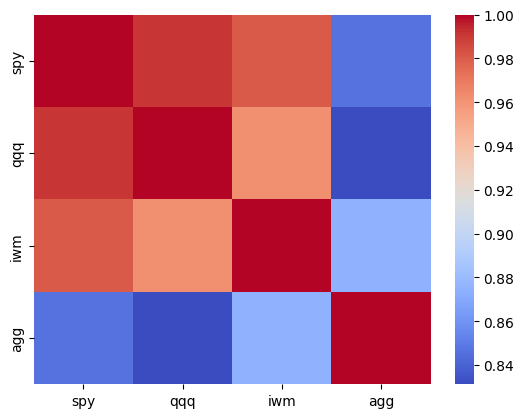

In [80]:
index_corr = get_corr(stocks = [spy, qqq, iwm, agg])
sns.heatmap(index_corr, cmap = 'coolwarm')

# Getting Data from one df

In [76]:
multiple = get_cumprod(get_close(thirty_years_ago, yesterday, tickers = 'spy qqq iwm agg'))

[*********************100%***********************]  4 of 4 completed


In [77]:
multiple.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:>

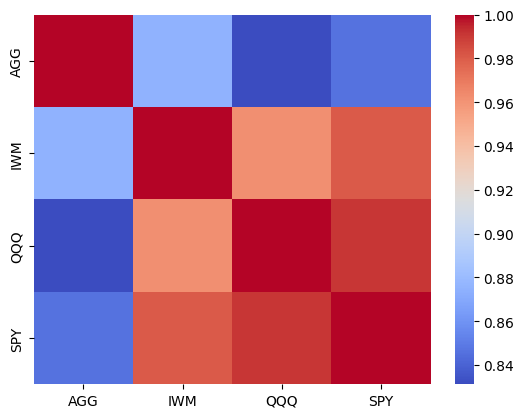

In [81]:
multiple_corr = multiple.corr()
sns.heatmap(multiple_corr, cmap = 'coolwarm')

In [82]:
multiple.std().hvplot.bar()

:Bars   [index]   (0)